In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.stats
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import os
import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib

In [2]:
#calcuate RMSRE (rooted mean squared relative errors)
#each sub

def RMSRE(sub_to_true, sub_to_pred, sub):
    
    all_CHO_pred = []
    all_CHO_true = []
    all_pro_pred = []
    all_pro_true = []
    all_fat_pred = []
    all_fat_true = []
    
    
        
    all_CHO_true.extend(sub_to_true[sub][:,0].tolist())
    all_CHO_pred.extend(np.asarray(sub_to_pred[sub])[:,0].tolist())

    all_pro_true.extend(sub_to_true[sub][:,1].tolist())
    all_pro_pred.extend(np.asarray(sub_to_pred[sub])[:,1].tolist())

    all_fat_true.extend(sub_to_true[sub][:,2].tolist())
    all_fat_pred.extend(np.asarray(sub_to_pred[sub])[:,2].tolist())
        
        
        
        
    RelativeError_CHO_list = np.square(np.array(all_CHO_true) - np.array(all_CHO_pred))/(np.square(all_CHO_pred))
    sum_RelativeError_CHO = np.sum(RelativeError_CHO_list)
    mean_RelativeError_CHO = sum_RelativeError_CHO/float(len(RelativeError_CHO_list))
    RMSRE_CHO = math.sqrt(mean_RelativeError_CHO)
    
    RelativeError_pro_list = np.square(np.array(all_pro_true) - np.array(all_pro_pred))/(np.square(all_pro_pred))
    sum_RelativeError_pro = np.sum(RelativeError_pro_list)
    mean_RelativeError_pro = sum_RelativeError_pro/float(len(RelativeError_pro_list))
    RMSRE_pro = math.sqrt(mean_RelativeError_pro)
    
    RelativeError_fat_list = np.square(np.array(all_fat_true) - np.array(all_fat_pred))/(np.square(all_fat_pred))
    sum_RelativeError_fat = np.sum(RelativeError_fat_list)
    mean_RelativeError_fat = sum_RelativeError_fat/float(len(RelativeError_fat_list))
    RMSRE_fat = math.sqrt(mean_RelativeError_fat)
    
    
    return RMSRE_CHO, RMSRE_pro, RMSRE_fat
    #RMSRE_CHO = math.sqrt( /float(len(all_CHO_true)))

In [3]:
def RMSRE_mean_std_allsubs(sub_to_true, sub_to_pred, all_sub_list):
    
    all_RMSRE_CHO_list = []
    all_RMSRE_pro_list = []
    all_RMSRE_fat_list = []
    
    for sub in all_sub_list:
        RMSRE_1tuple = RMSRE(sub_to_true, sub_to_pred, sub)
        
        all_RMSRE_CHO_list.append(RMSRE_1tuple[0])
        all_RMSRE_pro_list.append(RMSRE_1tuple[1])
        all_RMSRE_fat_list.append(RMSRE_1tuple[2])
        
    RMSRE_CHO_mean = np.mean(all_RMSRE_CHO_list)
    RMSRE_CHO_std = np.std(all_RMSRE_CHO_list)
    
    RMSRE_pro_mean = np.mean(all_RMSRE_pro_list)
    RMSRE_pro_std = np.std(all_RMSRE_pro_list)
    
    RMSRE_fat_mean = np.mean(all_RMSRE_fat_list)
    RMSRE_fat_std = np.std(all_RMSRE_fat_list)
        
    return (RMSRE_CHO_mean, RMSRE_CHO_std), (RMSRE_pro_mean, RMSRE_pro_std), (RMSRE_pro_mean, RMSRE_pro_std) 

In [4]:
def macro_recall(confusion_matrix):
    n = 0
    accumulated_recall = 0
    for row in confusion_matrix:
        accumulated_recall += row[n]/np.sum(row)
        n += 1
        
    return accumulated_recall/(n)

In [5]:
all_sub_list = ['38A', '38B', '38C', '38D', '38E', '38F', '38H']

all_comp_list = ['CHO', 'pro', 'fat']

sub_LBM = {'38A': 39.47,
           '38B': 62.78,
           '38C': 53.5,
           '38D': 37.47,
           '38E': 45.52,
           '38F': 43.38,
           '38H': 47.39}

sub_BW = {'38A': 70.1,
          '38B': 96.51,
          '38C': 84.4,
          '38D': 65.1,
          '38E': 78.8,
          '38F': 68.4,
          '38H': 88.8}

sub_BMI = {'38A': 30.9,
           '38B': 33.7,
           '38C': 31,
           '38D': 27,
           '38E': 32,
           '38F': 27.9,
           '38H': 29}

sub_FM = {'38A':  26.8371,
           '38B': 28.7399,
           '38C': 24.7426,
           '38D': 26.0123,
           '38E': 32.4202,
           '38F': 23.9422,
           '38H': 39.7503}

In [6]:
########################################################
#raw data
########################################################

#spreadsheet = '../../CGM_insulin_TG_data.xlsx'

def get_raw_data(blood_analyte, spreadsheet, labelscaled='LBM'):
    #subject_id = '38A'
    #blood_analyte = 'CGM'

    xl = pd.ExcelFile(spreadsheet)
    Meal_dfs = xl.parse(blood_analyte)
    sub_meal_idx = {}

    
    
    
    
    X=[]
    Y1=[]
    Y2=[]
    Y3=[]

    for index, row in Meal_dfs.iterrows():

        #ignore missing meals
        if not math.isnan(row.tolist()[6]):

            #get each subject's meal index
            for subject_id in ['38A', '38B', '38C', '38D', '38E', '38F', '38H']:
                if row['Patient_ID'] == subject_id:
                    if subject_id in sub_meal_idx:
                        sub_meal_idx[subject_id] += [index]
                    else:
                        sub_meal_idx[subject_id] = [index]




        X += [np.float32(one_cgm) for one_cgm in row.tolist()[2:34]]

        #carbs
        if row['Meal_ID'][4]== '1':
            Y1 += [np.float32(52.25)]
            #Y1 += [np.float32(1)]
        elif row['Meal_ID'][4]== '2':
            Y1 += [np.float32(94.75)]
            #Y1 += [np.float32(2)]
        elif row['Meal_ID'][4]== '3':
            Y1 += [np.float32(179.75)]
            #Y1 += [np.float32(3)]

        #protein
        if row['Meal_ID'][1]== '1':
            Y2 += [np.float32(15)]
            #Y2 += [np.float32(1)]
        elif row['Meal_ID'][1]== '2':
            Y2 += [np.float32(30)]
            #Y2 += [np.float32(2)]
        elif row['Meal_ID'][1]== '3':
            Y2 += [np.float32(60)]
            #Y2 += [np.float32(3)]

        #fat
        if row['Meal_ID'][7]== '1':
            Y3 += [np.float32(13)]    
            #Y3 += [np.float32(1)]  
        elif row['Meal_ID'][7]== '2':
            Y3 += [np.float32(26)]   
            #Y3 += [np.float32(2)]  
        elif row['Meal_ID'][7]== '3':
            Y3 += [np.float32(52)]  
            #Y3 += [np.float32(3)]



    X_value = np.array(X).reshape(63,32)
    scaler = StandardScaler()
    #X_value = scaler.fit_transform(X_value)
    Y1_value = np.array(Y1).reshape(-1,1)
    Y2_value = np.array(Y2).reshape(-1,1)
    Y3_value = np.array(Y3).reshape(-1,1)

    if labelscaled == 'LBM':
        
        #list of all LBM
        LBM_all = []
        
        for sub_id in all_sub_list:
            
            LBM_all.extend([sub_LBM[sub_id]]*9)
       
        #change to np array
        LBM_all=np.asarray(LBM_all).T.reshape(-1,1)
        
        
        Y1_value_scaled = np.true_divide(Y1_value, LBM_all)
        Y2_value_scaled = np.true_divide(Y2_value, LBM_all)
        Y3_value_scaled = np.true_divide(Y3_value, LBM_all)
        
        
        return X_value, Y1_value_scaled, Y2_value_scaled, Y3_value_scaled, sub_meal_idx


    elif labelscaled == 'BW':
        
        #list of all BW
        BW_all = []
        
        for sub_id in all_sub_list:
            
            BW_all.extend([sub_BW[sub_id]]*9)
       
        #change to np array
        BW_all=np.asarray(BW_all).T.reshape(-1,1)
        
        
        Y1_value_scaled = np.true_divide(Y1_value, BW_all)
        Y2_value_scaled = np.true_divide(Y2_value, BW_all)
        Y3_value_scaled = np.true_divide(Y3_value, BW_all)
        
        
        return X_value, Y1_value_scaled, Y2_value_scaled, Y3_value_scaled, sub_meal_idx


    elif labelscaled == 'BMI':
        
        #list of all BMI
        BMI_all = []
        
        for sub_id in all_sub_list:
            
            BMI_all.extend([sub_BMI[sub_id]]*9)
       
        #change to np array
        BMI_all=np.asarray(BMI_all).T.reshape(-1,1)
        
        
        Y1_value_scaled = np.true_divide(Y1_value, BMI_all)
        Y2_value_scaled = np.true_divide(Y2_value, BMI_all)
        Y3_value_scaled = np.true_divide(Y3_value, BMI_all)
        
        
        return X_value, Y1_value_scaled, Y2_value_scaled, Y3_value_scaled, sub_meal_idx


    elif labelscaled == 'FM':
        
        #list of all FM
        FM_all = []
        
        for sub_id in all_sub_list:
            
            FM_all.extend([sub_FM[sub_id]]*9)
       
        #change to np array
        FM_all=np.asarray(FM_all).T.reshape(-1,1)
        
        
        Y1_value_scaled = np.true_divide(Y1_value, FM_all)
        Y2_value_scaled = np.true_divide(Y2_value, FM_all)
        Y3_value_scaled = np.true_divide(Y3_value, FM_all)
        
        
        return X_value, Y1_value_scaled, Y2_value_scaled, Y3_value_scaled, sub_meal_idx


    elif labelscaled == 'MinMax':
        Y1_value_MinMax = (Y1_value - Y1_value.min())/ (Y1_value.max() - Y1_value.min())
        Y2_value_MinMax = (Y2_value - Y2_value.min())/ (Y2_value.max() - Y2_value.min())
        Y3_value_MinMax = (Y3_value - Y3_value.min())/ (Y3_value.max() - Y3_value.min())
        
        return X_value, Y1_value_MinMax, Y2_value_MinMax, Y3_value_MinMax, sub_meal_idx
        
        
    #for classification
    elif labelscaled == '1hot':
        
        #one hot encoding
        s = pd.Series(Y1_value.reshape(63,))
        Y1_value_1hot = pd.get_dummies(s)
        Y1_value_1hot = Y1_value_1hot.values

        s = pd.Series(Y2_value.reshape(63,))
        Y2_value_1hot = pd.get_dummies(s)
        Y2_value_1hot = Y2_value_1hot.values

        s = pd.Series(Y3_value.reshape(63,))
        Y3_value_1hot = pd.get_dummies(s)
        Y3_value_1hot = Y3_value_1hot.values
        
        return X_value, Y1_value_1hot, Y2_value_1hot, Y3_value_1hot, sub_meal_idx
        
    else:

        return X_value, Y1_value, Y2_value, Y3_value, sub_meal_idx

In [7]:
########################################################
# 17 Gaussian AUC features
########################################################

#data=pd.DataFrame(pd.read_excel('../../CGM_insulin_TG_data.xlsx'))
#feature_num can be 5 or 17


def get_Gau_features(blood_analyte, spreadsheet, feature_num, add_demo, relative_AUC):
    
    xl = pd.ExcelFile(spreadsheet)
    data = xl.parse(blood_analyte)
    
    def process_data(data):
        sample_am = data.shape[0]
        #deprecated for these labels
        protein = data.iloc[:, 1].values.reshape(-1, 1)
        cho = data.iloc[:, 2].values.reshape(-1, 1)
        fat = data.iloc[:, 3].values.reshape(-1, 1)
        # pudding_A = data_38A.iloc[:,4].values.reshape(-1,1)
        # water = data_38A.iloc[:,5].values.reshape(-1,1)
        total_e = data.iloc[:, 6].values.reshape(-1, 1)
        glucose = data.iloc[:, 2:35].values.reshape(sample_am, -1)
        #glucose_last_column = glucose[:, -1]
        #glucose_r = np.c_[glucose, glucose_last_column]
        #return protein, cho, fat, total_e, glucose
        if relative_AUC == True:
            return protein, cho, fat, total_e, offset_to_baseline(glucose)
            
        elif relative_AUC == False:
            return protein, cho, fat, total_e, glucose
            
        
    
    def offset_to_baseline(a):
        #a = np.array([[1,2,3],[4,5,6]]) 
        averages = np.array([])
        for idx, row in enumerate(a):
            averages = np.append(averages, np.mean(row[:3]))
        averages = averages.reshape(a.shape[0], 1)
        averages_new = np.tile(averages, a.shape[1])
        return a - averages_new
    
    def process_glucose(glucose, feature_num):
        a = np.zeros((1, feature_num))
        for row in glucose:
            # print(glucose_gaussian_feature_4(row).shape())
            # print(glucose_gaussian_feature_8(row).shape())
            # print(glucose_gaussian_feature_16(row).shape())
            
            if feature_num == 17:
                glucose_gaussian_feature = np.hstack((glucose_gaussian_feature_4(row),
                                                      glucose_gaussian_feature_8(row),
                                                      glucose_gaussian_feature_16(row)))
            elif feature_num == 5:
                glucose_gaussian_feature = np.hstack((glucose_gaussian_feature_8(row)))
                
            a = np.vstack([a, glucose_gaussian_feature])
        # print(a.shape)
        a = np.delete(a, 0, axis=0)
        # print(a.shape)
        return a
    
    def normal_function(mu, sigma, x):
        normal_function_value = (1 / (sigma * np.sqrt(2 * np.pi))) * \
            np.exp(-((x - mu) ** 2) / (2 * (sigma ** 2)))
        return normal_function_value
    
    def glucose_gaussian_feature_4(glucose_row):
        gaussian_feature = []
        normal_g_1 = normal_function(
            0, 4/1.96, np.asarray([i for i in range(0, 5)])) * glucose_row[0:5]
        normal_g_2 = normal_function(
            4, 4/1.96, np.asarray([i for i in range(0, 9)])) * glucose_row[0:9]
        normal_g_3 = normal_function(
            8, 4/1.96, np.asarray([i for i in range(4, 13)])) * glucose_row[4:13]
        normal_g_4 = normal_function(
            12, 4/1.96, np.asarray([i for i in range(8, 17)])) * glucose_row[8:17]
        normal_g_5 = normal_function(
            16, 4/1.96, np.asarray([i for i in range(12, 21)])) * glucose_row[12:21]
        normal_g_6 = normal_function(
            20, 4/1.96, np.asarray([i for i in range(16, 25)])) * glucose_row[16:25]
        normal_g_7 = normal_function(
            24, 4/1.96, np.asarray([i for i in range(20, 29)])) * glucose_row[20:29]
        normal_g_8 = normal_function(
            28, 4/1.96, np.asarray([i for i in range(24, 33)])) * glucose_row[24:33]
        normal_g_9 = normal_function(
            32, 4/1.96, np.asarray([i for i in range(28, 33)])) * glucose_row[28:33]
        for i in range(1, 10):
            gaussian_feature.append(np.trapz(locals()["normal_g_" + str(i)]))
        return gaussian_feature
    
    def glucose_gaussian_feature_8(glucose_row):
        gaussian_feature = []
        normal_g_1 = normal_function(
            0, 8/1.96, np.asarray([i for i in range(0, 9)])) * glucose_row[0:9]
        normal_g_2 = normal_function(
            8, 8/1.96, np.asarray([i for i in range(0, 17)])) * glucose_row[0:17]
        normal_g_3 = normal_function(
            16, 8/1.96, np.asarray([i for i in range(8, 25)])) * glucose_row[8:25]
        normal_g_4 = normal_function(
            24, 8/1.96, np.asarray([i for i in range(16, 33)])) * glucose_row[16:33]
        normal_g_5 = normal_function(
            32, 8/1.96, np.asarray([i for i in range(24, 33)])) * glucose_row[24:33]
        for i in range(1, 6):
            gaussian_feature.append(np.trapz(locals()["normal_g_" + str(i)]))
        return gaussian_feature
    
    def glucose_gaussian_feature_16(glucose_row):
        gaussian_feature = []
        normal_g_1 = normal_function(
            0, 16/1.96, np.asarray([i for i in range(0, 17)])) * glucose_row[0:17]
        normal_g_2 = normal_function(
            16, 16/1.96, np.asarray([i for i in range(0, 33)])) * glucose_row[0:33]
        normal_g_3 = normal_function(
            32, 16/1.96, np.asarray([i for i in range(16, 33)])) * glucose_row[16:33]
        for i in range(1, 4):
            gaussian_feature.append(np.trapz(locals()["normal_g_" + str(i)]))
        return gaussian_feature
    
    
    p,c,f,e,r=process_data(data)
    newfeature=process_glucose(r, feature_num)

    X_Gau = newfeature

    if add_demo == True:
        
        all_BM_list = []
        all_BMI_list = []
        all_FM_list = []
        all_LBM_list = []
        
        for sub_id in all_sub_list:
            for i in range(9):
                all_BM_list.append(sub_BW[sub_id])
                all_BMI_list.append(sub_BMI[sub_id])
                all_FM_list.append(sub_FM[sub_id])
                all_LBM_list.append(sub_LBM[sub_id])
                
        all_BM_list = np.asarray(all_BM_list).reshape(-1,1)
        all_BMI_list = np.asarray(all_BMI_list).reshape(-1,1)
        all_FM_list = np.asarray(all_FM_list).reshape(-1,1)
        all_LBM_list = np.asarray(all_LBM_list).reshape(-1,1)

        
        X_Gau_demo = np.hstack((X_Gau, all_BM_list, all_BMI_list, all_FM_list, all_LBM_list))
        
        return X_Gau_demo
        
        
    elif add_demo == False:
        
    
        return X_Gau

In [8]:
######################################
#training + parameter search
######################################

#return meal prediction, ground truth, and meal score
def ConstructModel_PrintResult(gpu_num, Input_X, Y1_value, Y2_value, Y3_value, sub, sub_meal_idx , 
                               shared_neuron, learning_rate_1_ls, learning_rate_2_ls, learning_rate_3_ls,
                               scenario = 'L1MO',  N_epochs=55, verbose=True):



    

    

    #Y1=carbs     Y2=protein      Y3=fat


    #options: X_value     X_Gau   X_both
    Input_X = Input_X



    #loss => all default huber

    #choose between L1SO vs. L1MO
    scenario = scenario

    L1MO_test_subs = [sub]
    
    L1SO_test_subs = [sub]

    neuron_shared_ls = shared_neuron

    learning_rate_1_ls = [0.0001]

    learning_rate_2_ls = [0.0001]

    learning_rate_3_ls = [0.0001]

    #5 0.001 0.001 0.005



    N_epochs = N_epochs
    
    #for reproducibility on NN
    np.random.seed(5)

    metrics_CHO = []
    metrics_pro = []
    metrics_fat = []


    #to average the results for a number of runs
    #for num_of_runs in range(30):

    #____________________________________________
    #if not for grid search, can be commented out
    for neurons_shared in neuron_shared_ls:
        for learning_rate_1 in learning_rate_1_ls:
            for learning_rate_2 in learning_rate_2_ls:
                for learning_rate_3 in learning_rate_3_ls:

                    '''
                    neurons_shared = 3
                    learning_rate_1 = 0.001
                    learning_rate_2 = 0.005
                    learning_rate_3 = 0.005
                    '''


                    # ======================
                    # Define the Graph
                    # ======================
                    

                    # Define the Placeholders for output layer
                    X = tf.placeholder("float", [None, Input_X.shape[1]], name="X")
                    Y1 = tf.placeholder("float", [None, Y1_value.shape[1]], name="Y1")
                    Y2 = tf.placeholder("float", [None, Y2_value.shape[1]], name="Y2")
                    Y3 = tf.placeholder("float", [None, Y3_value.shape[1]], name="Y3")

                    # Initial random weights for the layers
                    #shared layer weights
                    initial_shared_layer_weights = np.random.rand(Input_X.shape[1],neurons_shared)
                    #print(initial_shared_layer_weights)
                    initial_Y1_layer_weights = np.random.rand(neurons_shared, Y1_value.shape[1])
                    #print(initial_Y1_layer_weights)
                    initial_Y2_layer_weights = np.random.rand(neurons_shared, Y2_value.shape[1])
                    #print(initial_Y2_layer_weights)
                    initial_Y3_layer_weights = np.random.rand(neurons_shared, Y3_value.shape[1])
                    #print(initial_Y3_layer_weights)

                    #define the variable objects for the weights
                    shared_layer_weights = tf.Variable(initial_shared_layer_weights, name="share_W", dtype="float32")
                    Y1_layer_weights = tf.Variable(initial_Y1_layer_weights, name="share_Y1", dtype="float32")
                    Y2_layer_weights = tf.Variable(initial_Y2_layer_weights, name="share_Y2", dtype="float32")
                    Y3_layer_weights = tf.Variable(initial_Y3_layer_weights, name="share_Y3", dtype="float32")



                    #Define the biases for the layers
                    #shared layer bias
                    initial_shared_layer_bias = np.random.rand(neurons_shared,)
                    #print('bias')
                    #print(initial_shared_layer_bias)
                    initial_Y1_layer_bias = np.random.rand(Y1_value.shape[1])
                    #print(initial_Y1_layer_bias)
                    initial_Y2_layer_bias = np.random.rand(Y2_value.shape[1])
                    #print(initial_Y2_layer_bias)
                    initial_Y3_layer_bias = np.random.rand(Y3_value.shape[1])
                    #print(initial_Y3_layer_bias)

                    shared_layer_bias = tf.Variable(initial_shared_layer_bias, name="share_B", dtype="float32")
                    Y1_layer_bias = tf.Variable(initial_Y1_layer_bias, name="share_Y1_B", dtype="float32")
                    Y2_layer_bias = tf.Variable(initial_Y2_layer_bias, name="share_Y2_B", dtype="float32")
                    Y3_layer_bias = tf.Variable(initial_Y3_layer_bias, name="share_Y3_B", dtype="float32")



                    # Construct the Layers with RELU Activations
                    shared_layer = tf.nn.relu(tf.add(tf.matmul(X,shared_layer_weights), shared_layer_bias))
                    #Y1_layer = tf.nn.relu(tf.add(tf.matmul(shared_layer,Y1_layer_weights), Y1_layer_bias))
                    #Y2_layer = tf.nn.relu(tf.add(tf.matmul(shared_layer,Y2_layer_weights), Y2_layer_bias))
                    #Y3_layer = tf.nn.relu(tf.add(tf.matmul(shared_layer,Y3_layer_weights), Y3_layer_bias))
                    Y1_layer = tf.add(tf.matmul(shared_layer,Y1_layer_weights), Y1_layer_bias)
                    Y2_layer = tf.add(tf.matmul(shared_layer,Y2_layer_weights), Y2_layer_bias)
                    Y3_layer = tf.add(tf.matmul(shared_layer,Y3_layer_weights), Y3_layer_bias)




                    # Calculate Loss
                    #Y1_Loss = tf.nn.l2_loss(Y1-Y1_layer)
                    #Y1_Loss = tf.norm(Y1-Y1_layer, ord= 1)
                    #Y1_Loss = tf.losses.mean_squared_error(Y1, Y1_layer)
                    Y1_Loss = tf.losses.huber_loss(Y1, Y1_layer)
                    #Y1_Loss = tf.keras.losses.logcosh(Y1, Y1_layer)
                    #Y1_Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y1_layer, labels=Y1))

                    #Y2_Loss = tf.nn.l2_loss(Y2-Y2_layer)
                    #Y2_Loss = tf.norm(Y2-Y2_layer, ord= 1)
                    #Y2_Loss = tf.losses.mean_squared_error(Y2, Y2_layer)
                    Y2_Loss = tf.losses.huber_loss(Y2, Y2_layer)
                    #Y2_Loss = tf.keras.losses.logcosh(Y2, Y2_layer)
                    #Y2_Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y2_layer, labels=Y2))

                    #Y3_Loss = tf.nn.l2_loss(Y3-Y3_layer)
                    #Y3_Loss = tf.norm(Y3-Y3_layer, ord= 1)
                    #Y3_Loss = tf.losses.mean_squared_error(Y3, Y3_layer)
                    Y3_Loss = tf.losses.huber_loss(Y3, Y3_layer)
                    #Y3_Loss = tf.keras.losses.logcosh(Y3, Y3_layer)
                    #Y3_Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y3_layer, labels=Y3))

                    Joint_Loss = Y1_Loss + Y2_Loss + Y3_Loss

                    # optimisers
                    Optimiser = tf.train.AdamOptimizer().minimize(Joint_Loss)
                    Y1_op = tf.train.AdamOptimizer(learning_rate=learning_rate_1, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(Y1_Loss)
                    Y2_op = tf.train.AdamOptimizer(learning_rate=learning_rate_2, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(Y2_Loss)
                    Y3_op = tf.train.AdamOptimizer(learning_rate=learning_rate_3, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(Y3_Loss)










                    #__________________________________________________________________________________________________________
                    # Joint Training
                    # Calculation (Session) Code
                    # ==========================

                    # open the session
                    session = tf.InteractiveSession()




                    ################################ L1SO #####################################################################
                    ################################ L1SO #####################################################################
                    ################################ L1SO #####################################################################
                    ################################ L1SO #####################################################################
                    if scenario == 'L1SO':

                        sub_to_correlation = {}


                        for test_sub in L1SO_test_subs: 


                            if test_sub not in sub_to_correlation:
                                sub_to_correlation[test_sub] = {}


                            Y1_loss_list = []
                            Y2_loss_list = []
                            Y3_loss_list = []
                            Joint_loss_list = []


                            session.run(tf.global_variables_initializer())
                            
                            
                            #For calculating AUC purpose
                            all_meal_score = []

                            all_meal_pred = []
                            all_meal_true = []

                            #######  training phase  ###########
                            for i in range(1, N_epochs):


                                train_meal_idx = []
                                for one_sub in sub_meal_idx:
                                    if one_sub != test_sub:
                                        train_meal_idx += sub_meal_idx[one_sub]
                                
                                
                                
                                random.shuffle(train_meal_idx)

                                
                                for meal_idx in train_meal_idx:
                                    rand_nb = np.random.rand()
                                    if rand_nb < 0.25:
                                        _, Y1_loss = session.run([Y1_op, Y1_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value[meal_idx, :].reshape(-1,1),
                                                          Y2: Y2_value[meal_idx, :].reshape(-1,1),
                                                          Y3: Y3_value[meal_idx, :].reshape(-1,1)
                                                          })

                                        Y1_loss_list += [float(str(Y1_loss))]

                                    elif 0.25 <= rand_nb < 0.5:
                                        _, Y2_loss = session.run([Y2_op, Y2_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value[meal_idx, :].reshape(-1,1),
                                                          Y2: Y2_value[meal_idx, :].reshape(-1,1),
                                                          Y3: Y3_value[meal_idx, :].reshape(-1,1)
                                                          })

                                        Y2_loss_list += [float(str(Y2_loss))]

                                    elif 0.5 <= rand_nb < 0.75:
                                        _, Y3_loss = session.run([Y3_op, Y3_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value[meal_idx, :].reshape(-1,1),
                                                          Y2: Y2_value[meal_idx, :].reshape(-1,1),
                                                          Y3: Y3_value[meal_idx, :].reshape(-1,1)
                                                          })

                                        Y3_loss_list += [float(str(Y3_loss))]
                                        
                                    
                                    else:
                                        _, Joint_loss = session.run([Optimiser, Joint_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value[meal_idx, :].reshape(-1,1),
                                                          Y2: Y2_value[meal_idx, :].reshape(-1,1),
                                                          Y3: Y3_value[meal_idx, :].reshape(-1,1)
                                                          })
                                        Joint_loss_list += [float(str(Joint_loss))]

                                    

                                if i % 50 == 0:
                                    print('y1 loss: ', Y1_loss, end=' |')
                                    print('y2 loss: ', Y2_loss, end=' |')
                                    print('y3 loss: ', Y3_loss, end=' |')
                                    print('joint loss: ', Joint_loss)



                            #######  testing phase  ###########
                            for test_meal in sub_meal_idx[test_sub]:
                                Y1_pred, Y2_pred, Y3_pred = session.run([Y1_layer,Y2_layer,Y3_layer], {
                                                      X: Input_X[test_meal].reshape(-1,Input_X.shape[1]),
                                                      Y1: Y1_value[test_meal].reshape(-1,1),
                                                      Y2: Y2_value[test_meal].reshape(-1,1),
                                                      Y3: Y3_value[test_meal].reshape(-1,1)
                                                      })
                                
                                all_meal_score += [[Y1_pred[0][0], Y2_pred[0][0], Y3_pred[0][0]]]
                                all_meal_pred +=  [[Y1_pred[0][0], Y2_pred[0][0], Y3_pred[0][0]]]
                                
                                all_meal_true += [[Y1_value[test_meal][0], Y2_value[test_meal][0], Y3_value[test_meal][0]]]

                        

                            #######  plotting phase  ###########
                            corr_cx = []
                            corr_cy = []
                            corr_px = []
                            corr_py = []
                            corr_fx = []
                            corr_fy = []


                            for meal_num in range(len(all_meal_true)):
                                corr_cx.append(all_meal_pred[meal_num][0])
                                corr_cy.append(all_meal_true[meal_num][0])

                                corr_px.append(all_meal_pred[meal_num][1])
                                corr_py.append(all_meal_true[meal_num][1])

                                corr_fx.append(all_meal_pred[meal_num][2])
                                corr_fy.append(all_meal_true[meal_num][2])    

                            
                            sub_to_correlation[test_sub] = {'c':scipy.stats.pearsonr(corr_cy, corr_cx),
                                                            'p':scipy.stats.pearsonr(corr_py, corr_px),
                                                            'f':scipy.stats.pearsonr(corr_fy, corr_fx)}



                            
                            plt.subplot(411)
                            plt.plot(Y1_loss_list)
                            plt.subplot(412)
                            plt.plot(Y2_loss_list)
                            plt.subplot(413)
                            plt.plot(Y3_loss_list)
                            plt.subplot(414)
                            plt.plot(Joint_loss_list)
                            plt.show()
                            

                            print(test_sub[-1]+'_CHO = ',corr_cx)
                            print('truth_'+test_sub[-1]+'_CHO = ',corr_cy)
                            print(test_sub[-1]+'_pro = ',corr_px)
                            print('truth_'+test_sub[-1]+'_pro = ',corr_py)
                            print(test_sub[-1]+'_fat = ',corr_fx)
                            print('truth_'+test_sub[-1]+'_fat = ',corr_fy)


                        print(neurons_shared, learning_rate_1, learning_rate_2, learning_rate_3) 
                        print(sub_to_correlation)


                        print(max(Y1_loss_list))
                        print(max(Y2_loss_list))  
                        print(max(Y3_loss_list))



                    ################################## L1MO #####################################################################  
                    ################################## L1MO #####################################################################
                    ################################## L1MO #####################################################################
                    ################################## L1MO #####################################################################
                    elif scenario == 'L1MO':

                        sub_to_correlation = {}

                        #for test_sub in ['38A', '38B', '38C', '38D', '38E', '38F', '38H']: 
                        #for test_sub in ['38B']: 
                        for test_sub in L1MO_test_subs:

                            
                            test_sub_BW = sub_BW[test_sub]
                            test_sub_BMI = sub_BMI[test_sub]
                            test_sub_LBM = sub_LBM[test_sub]
                            test_sub_FM = sub_FM[test_sub]
                            
                            test_sub_demo_info = [test_sub_BW, test_sub_BMI, test_sub_LBM, test_sub_FM]
                            
                            if test_sub not in sub_to_correlation:
                                 sub_to_correlation[test_sub] = {}


                            Y1_loss_list = []
                            Y2_loss_list = []
                            Y3_loss_list = []
                            Joint_loss_list = []

                            session.run(tf.global_variables_initializer())

                            #For calculating AUC purpose
                            all_meal_score = []

                            all_meal_pred = []
                            all_meal_true = []

                            for test_meal in sub_meal_idx[test_sub]:

                                #create training indexes
                                train_meal_idxes = []
                                for meal_index in sub_meal_idx[test_sub]:
                                    if meal_index != test_meal:
                                        train_meal_idxes.append(meal_index) 

                                print(test_sub, test_meal, train_meal_idxes)
                                #random.shuffle(train_meal_idxes)
                                
                                
                                #######  training phase  ###########
                                for i in range(1,N_epochs):
                                    for meal_idx in train_meal_idxes:

                                        rand_nb = np.random.rand()
                                        if rand_nb < 0.333:
                                            _, Y1_loss = session.run([Y1_op, Y1_Loss],
                                                            {
                                                              X: Input_X[train_meal_idxes, :].reshape(-1,Input_X.shape[1]),
                                                              Y1: Y1_value[train_meal_idxes, :].reshape(-1,1),
                                                              Y2: Y2_value[train_meal_idxes, :].reshape(-1,1),
                                                              Y3: Y3_value[train_meal_idxes, :].reshape(-1,1)
                                                              })

                                            Y1_loss_list += [float(str(Y1_loss))]

                                        elif 0.333 <= rand_nb < 0.666:
                                            _, Y2_loss = session.run([Y2_op, Y2_Loss],
                                                            {
                                                              X: Input_X[train_meal_idxes, :].reshape(-1,Input_X.shape[1]),
                                                              Y1: Y1_value[train_meal_idxes, :].reshape(-1,1),
                                                              Y2: Y2_value[train_meal_idxes, :].reshape(-1,1),
                                                              Y3: Y3_value[train_meal_idxes, :].reshape(-1,1)
                                                              })

                                            Y2_loss_list += [float(str(Y2_loss))]

                                        elif 0.666 <= rand_nb < 0.999:
                                            _, Y3_loss = session.run([Y3_op, Y3_Loss],
                                                            {
                                                              X: Input_X[train_meal_idxes, :].reshape(-1,Input_X.shape[1]),
                                                              Y1: Y1_value[train_meal_idxes, :].reshape(-1,1),
                                                              Y2: Y2_value[train_meal_idxes, :].reshape(-1,1),
                                                              Y3: Y3_value[train_meal_idxes, :].reshape(-1,1)
                                                              })

                                            Y3_loss_list += [float(str(Y3_loss))]

                                        '''    
                                        else:
                                            _, Joint_loss = session.run([Optimiser, Joint_Loss],
                                                            {
                                                              X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                              Y1: Y1_value[meal_idx, :].reshape(-1,1),
                                                              Y2: Y2_value[meal_idx, :].reshape(-1,1),
                                                              Y3: Y3_value[meal_idx, :].reshape(-1,1)
                                                              })
                                            Joint_loss_list += [float(str(Joint_loss))]
                                        '''

                                
                                if i % 50 == 0:
                                    print('y1 loss: ', Y1_loss, end=' |')
                                    print('y2 loss: ', Y2_loss, end=' |')
                                    print('y3 loss: ', Y3_loss, end=' |')
                                    #print('joint loss: ', Joint_loss)



                                #######  testing phase  ###########
                                Y1_pred, Y2_pred, Y3_pred = session.run([Y1_layer,Y2_layer,Y3_layer], {
                                                      X: Input_X[test_meal].reshape(-1,Input_X.shape[1]),
                                                      Y1: Y1_value[test_meal].reshape(-1,1),
                                                      Y2: Y2_value[test_meal].reshape(-1,1),
                                                      Y3: Y3_value[test_meal].reshape(-1,1)
                                                      })
                                
                                
                                all_meal_score += [[Y1_pred[0][0], Y2_pred[0][0], Y3_pred[0][0]]]
                                all_meal_pred += [[Y1_pred[0][0], Y2_pred[0][0], Y3_pred[0][0]]]
                                #all_meal_pred += [[np.argmax(Y1_pred[0]), np.argmax(Y2_pred[0]), np.argmax(Y3_pred[0])]]
                                all_meal_true += [[Y1_value[test_meal][0], Y2_value[test_meal][0], Y3_value[test_meal][0]]]



                            #######  plotting phase  ###########
                            corr_cx = []
                            corr_cy = []
                            corr_px = []
                            corr_py = []
                            corr_fx = []
                            corr_fy = []


                            for meal_num in range(len(all_meal_true)):
                                corr_cx.append(all_meal_pred[meal_num][0])
                                corr_cy.append(all_meal_true[meal_num][0])

                                corr_px.append(all_meal_pred[meal_num][1])
                                corr_py.append(all_meal_true[meal_num][1])

                                corr_fx.append(all_meal_pred[meal_num][2])
                                corr_fy.append(all_meal_true[meal_num][2])    

                            sub_to_correlation[test_sub] = {'c':scipy.stats.pearsonr(corr_cy, corr_cx),
                                                            'p':scipy.stats.pearsonr(corr_py, corr_px),
                                                            'f':scipy.stats.pearsonr(corr_fy, corr_fx)}




                            plt.subplot(411)
                            plt.plot(Y1_loss_list)
                            plt.subplot(412)
                            plt.plot(Y2_loss_list)
                            plt.subplot(413)
                            plt.plot(Y3_loss_list)
                            plt.subplot(414)
                            plt.plot(Joint_loss_list)
                            plt.show()


                        print(neurons_shared, learning_rate_1, learning_rate_2, learning_rate_3)    
                        print(sub_to_correlation)

                        print('c')
                        print(corr_cx, corr_cy)
                        #print(scipy.stats.pearsonr(corr_cy, corr_cx))
                        print('p')
                        print(corr_px, corr_py)
                        #print(scipy.stats.pearsonr(corr_py, corr_px))
                        print('f')
                        print(corr_fx, corr_fy) 
                        #print(scipy.stats.pearsonr(corr_fy, corr_fx))

                        metrics_CHO.append(scipy.stats.pearsonr(corr_cy, corr_cx))
                        metrics_pro.append(scipy.stats.pearsonr(corr_py, corr_px))
                        metrics_fat.append(scipy.stats.pearsonr(corr_fy, corr_fx))



                        #print(max(Y1_loss_list))
                        #print(max(Y2_loss_list))  
                        #print(max(Y3_loss_list))


    #print(metrics_CHO, metrics_pro, metrics_fat)

    all_meal_score = np.asarray(all_meal_score)
    all_meal_true = np.asarray(all_meal_true)
    
    return all_meal_score, all_meal_pred, all_meal_true, session


# evaluation functions

In [9]:
#evaluate one sub's all_meal_score, all_meal_true

def Evaluation_results(all_meal_score, all_meal_true, component = 0):

    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference


    #change logit number to probability
    def row_wise_softmax(all_meal_score):
        y_score = []

        for row in all_meal_score[:,0,:]:
            y_score.append(softmax(row))

        y_score = np.asarray(y_score)

        return y_score



    #carb: 0    protein: 1     fat:2
    def dummify_one_component(all_meal_true, component = 0):

        if all_meal_true.ndim >= 2:

            y_test = label_binarize(all_meal_true[:,component], classes=np.unique(all_meal_true[:,component]))

        else:

            y_test

        return y_test
    
    
    #prepare labels and proba for one of the components
    y_score = row_wise_softmax(all_meal_score)
    y_test = dummify_one_component(all_meal_true, component)
    
    return y_score, y_test

# =====================================================================================================================================
# =====================================================================================================================================
# =====================================================================================================================================
# =====================================================================================================================================
# run all experiment in one line
# =====================================================================================================================================
# =====================================================================================================================================

38A 0 [1, 2, 3, 4, 5, 6, 8]
38A 1 [0, 2, 3, 4, 5, 6, 8]
38A 2 [0, 1, 3, 4, 5, 6, 8]
38A 3 [0, 1, 2, 4, 5, 6, 8]
38A 4 [0, 1, 2, 3, 5, 6, 8]
38A 5 [0, 1, 2, 3, 4, 6, 8]
38A 6 [0, 1, 2, 3, 4, 5, 8]
38A 8 [0, 1, 2, 3, 4, 5, 6]


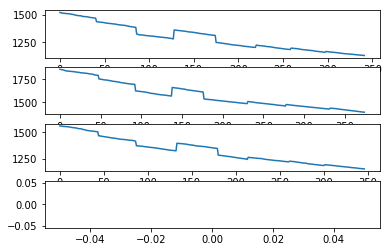

5 0.0001 0.0001 0.0001
{'38A': {'c': (0.809791496887048, 0.014843116163483402), 'p': (0.5873372361924606, 0.1257960744891962), 'f': (0.7768491677092891, 0.023338330913384286)}}
c
[1197.4326, 1344.994, 1684.178, 1065.2928, 1446.5175, 1254.0176, 1108.0396, 1014.96857] [0.7453637660485022, 1.3516405135520686, 2.5641940085592014, 0.7453637660485022, 2.5641940085592014, 1.3516405135520686, 1.3516405135520686, 1.3516405135520686]
p
[1457.8708, 1651.5895, 2066.9534, 1318.5521, 1762.3364, 1543.2609, 1367.5002, 1249.5153] [0.2139800285306705, 0.427960057061341, 0.855920114122682, 0.427960057061341, 0.427960057061341, 0.855920114122682, 0.2139800285306705, 0.427960057061341]
f
[1226.3405, 1421.6211, 1650.3068, 1104.5159, 1474.1028, 1274.8723, 1180.0693, 1060.54] [0.18544935805991442, 0.37089871611982883, 0.7417974322396577, 0.37089871611982883, 0.37089871611982883, 0.37089871611982883, 0.37089871611982883, 0.18544935805991442]


/home/grads/g/guangzhou92/enter/envs/py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


38B 10 [11, 12, 14, 15, 16, 17]
38B 11 [10, 12, 14, 15, 16, 17]
38B 12 [10, 11, 14, 15, 16, 17]
38B 14 [10, 11, 12, 15, 16, 17]
38B 15 [10, 11, 12, 14, 16, 17]
38B 16 [10, 11, 12, 14, 15, 17]
38B 17 [10, 11, 12, 14, 15, 16]


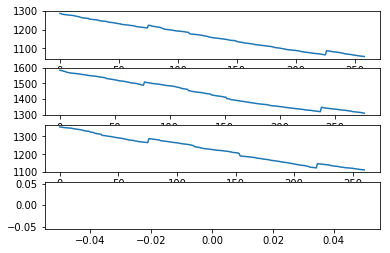

5 0.0001 0.0001 0.0001
{'38B': {'c': (0.3889493130019705, 0.3884900614960126), 'p': (0.28001848673358126, 0.5430416838432193), 'f': (0.519216658111069, 0.2323912080467354)}}
c
[1331.5981, 1284.5094, 1141.1198, 1140.846, 1120.638, 1085.9713, 923.3742] [0.9817635478188789, 1.8625012952025697, 0.5413946741270335, 0.9817635478188789, 0.9817635478188789, 0.9817635478188789, 0.9817635478188789]
p
[1628.1516, 1574.494, 1402.3298, 1397.03, 1398.5004, 1361.9675, 1145.3884] [0.31084861672365555, 0.6216972334473111, 0.31084861672365555, 0.6216972334473111, 0.15542430836182777, 0.31084861672365555, 0.31084861672365555]
f
[1366.4756, 1356.8702, 1175.591, 1166.1927, 1206.525, 1173.9934, 997.57367] [0.2694021344938348, 0.5388042689876696, 0.2694021344938348, 0.2694021344938348, 0.2694021344938348, 0.5388042689876696, 0.1347010672469174]
38C 18 [20, 21, 22, 23, 24, 25, 26]
38C 20 [18, 21, 22, 23, 24, 25, 26]
38C 21 [18, 20, 22, 23, 24, 25, 26]
38C 22 [18, 20, 21, 23, 24, 25, 26]
38C 23 [18, 20, 21, 22

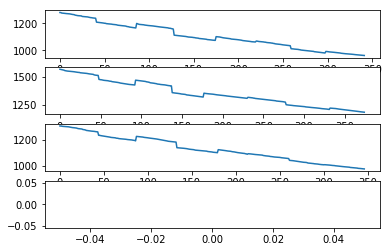

5 0.0001 0.0001 0.0001
{'38C': {'c': (0.6826475098942437, 0.06209240334694836), 'p': (0.33948266462001314, 0.4106851747365484), 'f': (0.297979004673278, 0.47348089806680344)}}
c
[1163.4237, 1299.1769, 1008.87897, 1269.9058, 1027.8215, 938.7009, 1045.6364, 927.74506] [0.6190758293838862, 2.1297393364928907, 0.6190758293838862, 2.1297393364928907, 1.1226303317535544, 1.1226303317535544, 1.1226303317535544, 1.1226303317535544]
p
[1420.5894, 1597.7803, 1238.1321, 1568.6759, 1267.8691, 1157.7019, 1271.6719, 1148.4988] [0.1777251184834123, 0.7109004739336492, 0.3554502369668246, 0.3554502369668246, 0.7109004739336492, 0.1777251184834123, 0.3554502369668246, 0.3554502369668246]
f
[1188.8871, 1313.6057, 1028.099, 1275.432, 1060.5797, 979.3118, 1035.383, 969.7931] [0.15402843601895733, 0.6161137440758293, 0.30805687203791465, 0.30805687203791465, 0.30805687203791465, 0.30805687203791465, 0.6161137440758293, 0.15402843601895733]
38D 27 [28, 29, 30, 31, 32, 33, 34, 35]
38D 28 [27, 29, 30, 31, 32,

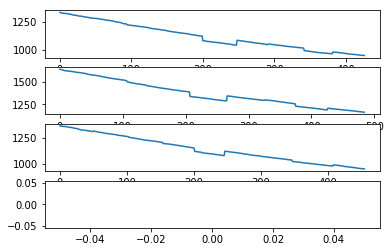

5 0.0001 0.0001 0.0001
{'38D': {'c': (0.3826622506505008, 0.3094148250776051), 'p': (0.013693692267082225, 0.9721077980572113), 'f': (-0.011146895761612097, 0.9772940816072153)}}
c
[1227.9458, 1154.4226, 1156.5359, 1125.1625, 1391.996, 986.1547, 891.7652, 1036.6257, 867.8585] [0.8026113671274963, 1.4554531490015363, 2.7611367127496163, 0.8026113671274963, 2.7611367127496163, 1.4554531490015363, 1.4554531490015363, 1.4554531490015363, 1.4554531490015363]
p
[1502.6198, 1419.1045, 1453.9552, 1394.8187, 1727.9182, 1208.1096, 1102.0447, 1261.2794, 1053.2681] [0.23041474654377883, 0.46082949308755766, 0.9216589861751153, 0.46082949308755766, 0.46082949308755766, 0.9216589861751153, 0.23041474654377883, 0.46082949308755766, 0.46082949308755766]
f
[1287.1235, 1185.8411, 1178.5645, 1193.8578, 1384.1884, 1001.5337, 945.54913, 1006.5073, 866.3985] [0.19969278033794163, 0.39938556067588327, 0.7987711213517665, 0.39938556067588327, 0.39938556067588327, 0.39938556067588327, 0.39938556067588327, 0.79

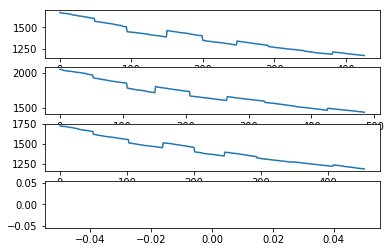

5 0.0001 0.0001 0.0001
{'38E': {'c': (0.697155717831752, 0.03685639331688249), 'p': (0.3468928046181743, 0.36039949018373196), 'f': (0.3956916148893297, 0.2918101748941813)}}
c
[1335.7517, 1526.9468, 1881.8977, 1232.6178, 1580.1768, 1166.715, 1214.8724, 1223.3623, 970.5352] [0.6630710659898478, 1.2024111675126905, 2.2810913705583755, 0.6630710659898478, 2.2810913705583755, 1.2024111675126905, 1.2024111675126905, 1.2024111675126905, 1.2024111675126905]
p
[1647.8193, 1872.5125, 2308.78, 1529.1509, 1946.9727, 1434.6771, 1510.8344, 1485.4093, 1191.0695] [0.1903553299492386, 0.3807106598984772, 0.7614213197969544, 0.3807106598984772, 0.3807106598984772, 0.7614213197969544, 0.1903553299492386, 0.3807106598984772, 0.3807106598984772]
f
[1401.9706, 1603.2637, 1856.0952, 1296.8058, 1654.16, 1220.5012, 1293.5232, 1199.2598, 1006.0567] [0.1649746192893401, 0.3299492385786802, 0.6598984771573604, 0.3299492385786802, 0.3299492385786802, 0.3299492385786802, 0.3299492385786802, 0.6598984771573604, 0.

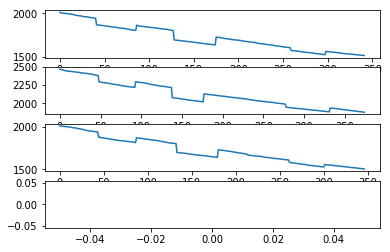

5 0.0001 0.0001 0.0001
{'38F': {'c': (0.6271568638311948, 0.09604290151072745), 'p': (-0.040050316879806855, 0.9249859194894386), 'f': (0.11564101008522919, 0.785098412303359)}}
c
[1647.2135, 2071.3176, 1560.2106, 2213.7874, 1518.7672, 1501.2012, 1652.4951, 1334.9059] [0.7638888888888888, 1.3852339181286548, 0.7638888888888888, 2.6279239766081868, 1.3852339181286548, 1.3852339181286548, 1.3852339181286548, 1.3852339181286548]
p
[2026.6804, 2532.77, 1909.5941, 2745.2017, 1889.1166, 1848.1177, 2062.0933, 1633.9077] [0.21929824561403508, 0.43859649122807015, 0.43859649122807015, 0.43859649122807015, 0.8771929824561403, 0.21929824561403508, 0.43859649122807015, 0.43859649122807015]
f
[1698.1549, 2037.5889, 1569.6647, 2216.1475, 1513.0833, 1491.8787, 1633.3423, 1348.6691] [0.19005847953216373, 0.38011695906432746, 0.38011695906432746, 0.38011695906432746, 0.38011695906432746, 0.38011695906432746, 0.7602339181286549, 0.19005847953216373]
38H 54 [55, 56, 58, 59, 61, 62]
38H 55 [54, 56, 58, 59

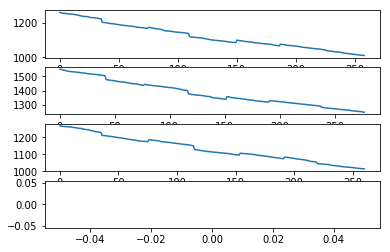

5 0.0001 0.0001 0.0001
{'38H': {'c': (0.3442306961382896, 0.44961465783663346), 'p': (-0.039907588342163014, 0.9323047101972975), 'f': (-0.29129114880446294, 0.5261987690412578)}}
c
[1138.5635, 1213.3685, 1131.2385, 1207.332, 1081.4017, 988.62225, 985.4226] [0.5884009009009009, 1.0670045045045045, 2.024211711711712, 2.024211711711712, 1.0670045045045045, 1.0670045045045045, 1.0670045045045045]
p
[1398.6129, 1491.1857, 1399.4633, 1485.3293, 1329.4843, 1218.0419, 1220.9806] [0.16891891891891891, 0.33783783783783783, 0.6756756756756757, 0.33783783783783783, 0.6756756756756757, 0.33783783783783783, 0.33783783783783783]
f
[1165.7694, 1227.0192, 1112.2184, 1199.1333, 1085.4099, 990.6678, 1011.9487] [0.1463963963963964, 0.2927927927927928, 0.5855855855855856, 0.2927927927927928, 0.2927927927927928, 0.5855855855855856, 0.1463963963963964]


In [10]:
spreadsheet = '../../CGM_insulin_TG_data.xlsx'


##########################################
##########################################
blood_analyte = 'CGM'


labelscaled = 'BW'
#None, 'LBM', 'BW', 'BMI', 'FM', 'MinMax'

feature_num = 17
#5, 17

add_demo = False

relative_AUC = False

scenario = 'L1MO'
#'L1SO', 'L1MO'

gpu_num = 6

N_epochs=20
#L1MO 20, L1SO 20


save_pickle_subtopredtrue = False
#if save sub_to_pred & sub_to_true


save_pickle_RMSRE = True
#if save all sub's RMSRE mean + std
##########################################
##########################################





os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
device_nb = gpu_num
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_nb)

#get raw 32 readings + labels 
#labelscaled: 'LBM'   'MinMax'    None
X_value, Y1_value, Y2_value, Y3_value, sub_meal_idx = get_raw_data(blood_analyte=blood_analyte, 
                                                                   spreadsheet=spreadsheet, 
                                                                   labelscaled = labelscaled)


#get Gaussian features
X_Gau = get_Gau_features(blood_analyte=blood_analyte, 
                         spreadsheet=spreadsheet, 
                         feature_num=feature_num, 
                         add_demo=add_demo, 
                         relative_AUC=relative_AUC)



##########################################
##########################################
Input_X = X_Gau  
#X_Gau, X_value
##########################################
##########################################





#sub to pred and labels
sub_to_pred = {}
sub_to_true = {}

all_sub_list = ['38A', '38B', '38C', '38D', '38E', '38F', '38H']



#test sub of LOMO or LOSO 
for sub in all_sub_list:


    #train/build model with different options
    all_meal_score, all_meal_pred, all_meal_true, session = ConstructModel_PrintResult(gpu_num=gpu_num, 
                                                                                       Input_X=Input_X,
                                                                                       Y1_value = Y1_value,
                                                                                       Y2_value = Y2_value,
                                                                                       Y3_value = Y3_value,
                                                                                       sub=sub, 
                                                                                       sub_meal_idx=sub_meal_idx,
                                                                                       shared_neuron = [5],
                                                                                       learning_rate_1_ls = [0.001], 
                                                                                       learning_rate_2_ls = [0.001], 
                                                                                       learning_rate_3_ls = [0.001],
                                                                                       scenario = scenario,
                                                                                       N_epochs=N_epochs,
                                                                                       verbose=True)
    
    
    sub_to_pred[sub] = all_meal_pred
    sub_to_true[sub] = all_meal_true
    

if save_pickle_subtopredtrue ==  True:
    import pickle

    pickle.dump(sub_to_pred, open( "sub_to_pred_%sAUCs.pkl"%(str(feature_num)), "wb" ) )
    pickle.dump(sub_to_true, open( "sub_to_true_%sAUCs.pkl"%(str(feature_num)), "wb" ) )
    
if save_pickle_RMSRE == True:
    
    file_directory = 'RMSRE/%s_label=%s|f_num=%s|demo=%s|Re_AUC=%s.txt'%(scenario,
                                                      labelscaled,
                                                      str(feature_num),
                                                      str(add_demo),
                                                      str(relative_AUC))

    
    with open(file_directory, 'w') as f0:
        f0.write('CHO_mean, CHO_std, pro_mean, pro_std, fat_mean, fat_std\n')
        f0.write(str(RMSRE_mean_std_allsubs(sub_to_true, sub_to_pred, all_sub_list)))
    



# =====================================================================================================================================

In [11]:
sub_to_pred

{'38A': [[1197.4326, 1457.8708, 1226.3405],
  [1344.994, 1651.5895, 1421.6211],
  [1684.178, 2066.9534, 1650.3068],
  [1065.2928, 1318.5521, 1104.5159],
  [1446.5175, 1762.3364, 1474.1028],
  [1254.0176, 1543.2609, 1274.8723],
  [1108.0396, 1367.5002, 1180.0693],
  [1014.96857, 1249.5153, 1060.54]],
 '38B': [[1331.5981, 1628.1516, 1366.4756],
  [1284.5094, 1574.494, 1356.8702],
  [1141.1198, 1402.3298, 1175.591],
  [1140.846, 1397.03, 1166.1927],
  [1120.638, 1398.5004, 1206.525],
  [1085.9713, 1361.9675, 1173.9934],
  [923.3742, 1145.3884, 997.57367]],
 '38C': [[1163.4237, 1420.5894, 1188.8871],
  [1299.1769, 1597.7803, 1313.6057],
  [1008.87897, 1238.1321, 1028.099],
  [1269.9058, 1568.6759, 1275.432],
  [1027.8215, 1267.8691, 1060.5797],
  [938.7009, 1157.7019, 979.3118],
  [1045.6364, 1271.6719, 1035.383],
  [927.74506, 1148.4988, 969.7931]],
 '38D': [[1227.9458, 1502.6198, 1287.1235],
  [1154.4226, 1419.1045, 1185.8411],
  [1156.5359, 1453.9552, 1178.5645],
  [1125.1625, 1394.8187

In [12]:
sub_to_true

{'38A': array([[0.74536377, 0.21398003, 0.18544936],
        [1.35164051, 0.42796006, 0.37089872],
        [2.56419401, 0.85592011, 0.74179743],
        [0.74536377, 0.42796006, 0.37089872],
        [2.56419401, 0.42796006, 0.37089872],
        [1.35164051, 0.85592011, 0.37089872],
        [1.35164051, 0.21398003, 0.37089872],
        [1.35164051, 0.42796006, 0.18544936]]),
 '38B': array([[0.98176355, 0.31084862, 0.26940213],
        [1.8625013 , 0.62169723, 0.53880427],
        [0.54139467, 0.31084862, 0.26940213],
        [0.98176355, 0.62169723, 0.26940213],
        [0.98176355, 0.15542431, 0.26940213],
        [0.98176355, 0.31084862, 0.53880427],
        [0.98176355, 0.31084862, 0.13470107]]),
 '38C': array([[0.61907583, 0.17772512, 0.15402844],
        [2.12973934, 0.71090047, 0.61611374],
        [0.61907583, 0.35545024, 0.30805687],
        [2.12973934, 0.35545024, 0.30805687],
        [1.12263033, 0.71090047, 0.30805687],
        [1.12263033, 0.17772512, 0.30805687],
        [

In [13]:
X_value, Y1_value_1hot, Y2_value_1hot, Y3_value_1hot, sub_meal_idx = get_raw_data(blood_analyte=blood_analyte, 
                                                                                  spreadsheet=spreadsheet, 
                                                                                  labelscaled = '1hot')

In [14]:
session.close()
from numba import cuda
cuda.select_device(0)
cuda.close()

# Root Mean Squared Relative Errors

In [15]:
RMSRE_mean_std_allsubs(sub_to_true, sub_to_pred, all_sub_list)

((0.9989159746943217, 0.00019725643333126045),
 (0.9997093092128261, 4.898922611537529e-05),
 (0.9997093092128261, 4.898922611537529e-05))

# plotting regression results

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid", {'axes.grid' : False})

/home/grads/g/guangzhou92/enter/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


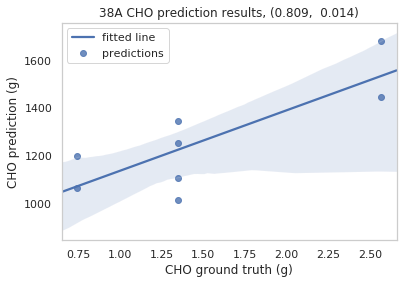

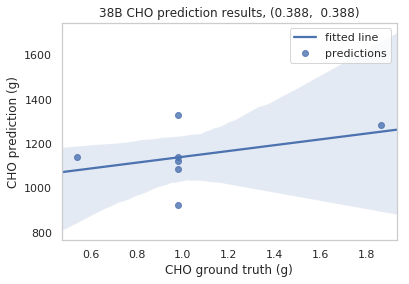

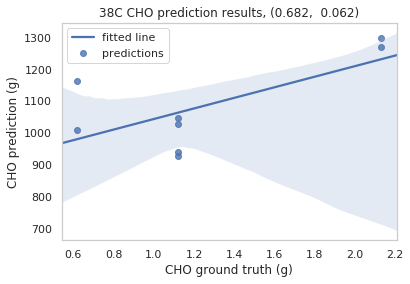

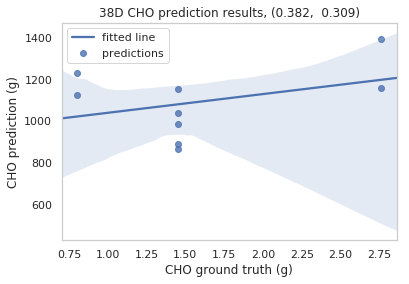

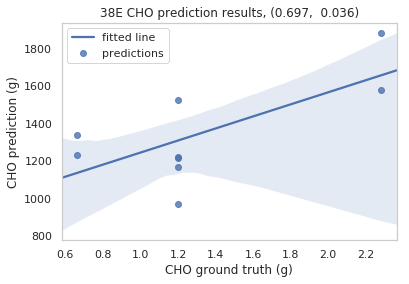

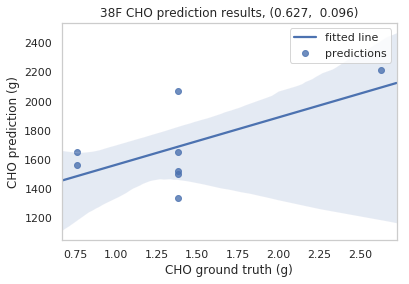

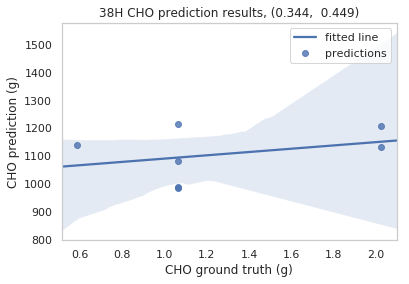

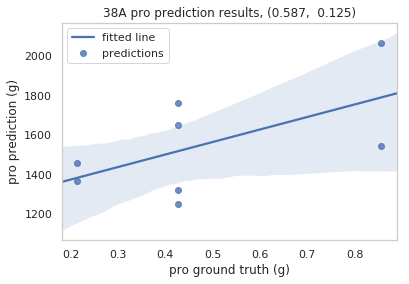

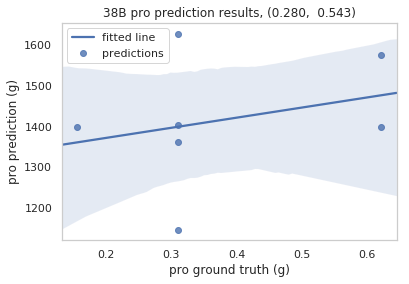

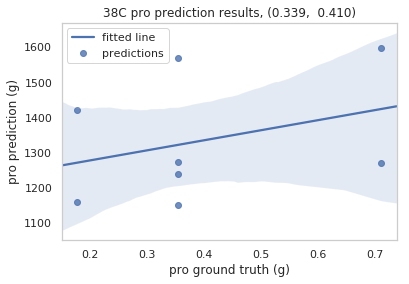

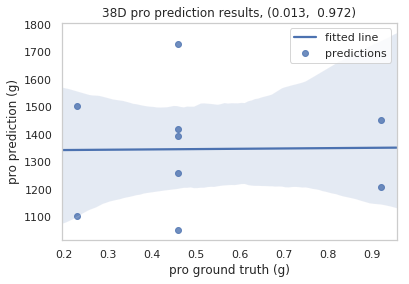

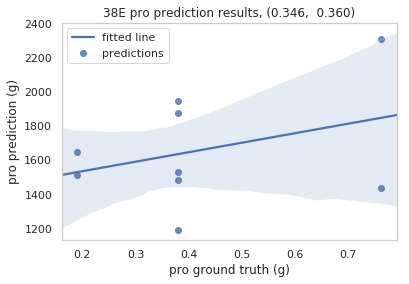

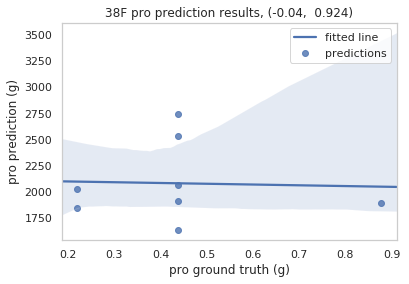

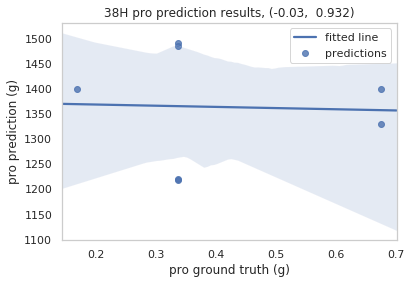

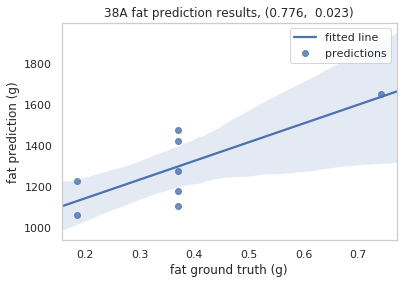

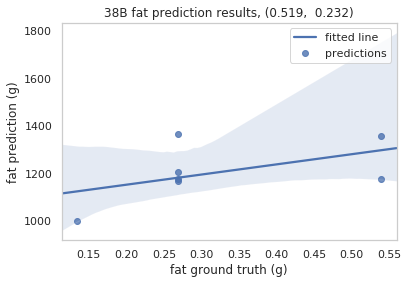

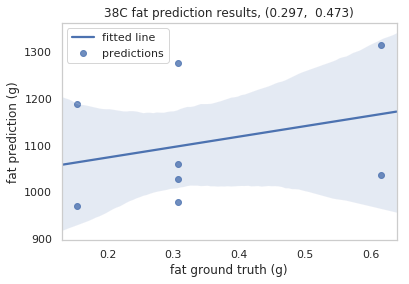

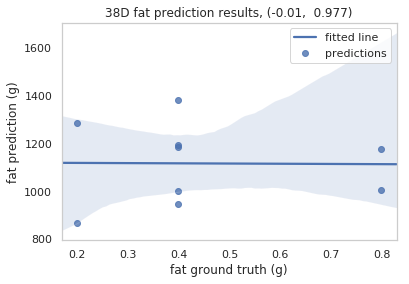

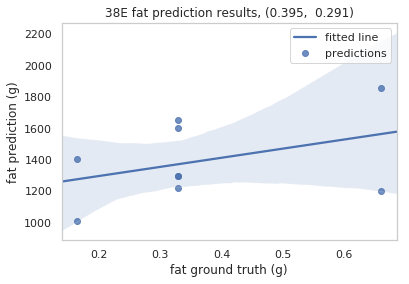

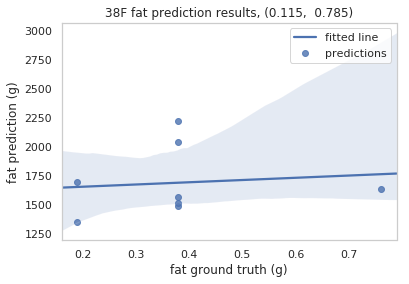

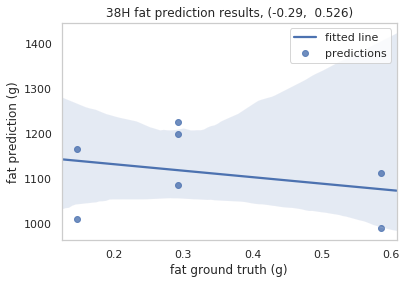

In [17]:
x_CHO = []
y_CHO = []
x_pro = []
y_pro = []
x_fat = []
y_fat = []
sub_to_correlation= {}


for i, comp in enumerate(all_comp_list):
    
    

    
    for sub in all_sub_list:
        fig, axs = plt.subplots(1,1)
        
        oneSub_x_oneComp = np.asarray(sub_to_pred[sub])[:,i]
        oneSub_y_oneComp = sub_to_true[sub][:,i]
        correlation_ = scipy.stats.pearsonr(oneSub_x_oneComp, oneSub_y_oneComp)
        correlation_ = str(correlation_)
        correlation_ = correlation_.split(',')
        correlation_ = correlation_[0][0:6] + ', ' + correlation_[1][0:6] + ')'

        if sub not in sub_to_correlation:
            sub_to_correlation[sub] = {}
            
        sub_to_correlation[sub][comp] = correlation_
        
        
        sns.regplot(oneSub_y_oneComp, oneSub_x_oneComp)
        plt.legend(('fitted line', 'predictions'))
        plt.title('%s %s prediction results, %s'%(sub,comp, correlation_))
        plt.xlabel('%s ground truth (g)'%comp)
        plt.ylabel('%s prediction (g)'%comp)
        
        
        if comp == 'CHO':
            file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/CHO/'%(scenario,
                                                                          labelscaled,
                                                                          str(feature_num),
                                                                          str(add_demo),
                                                                          str(relative_AUC))
            
        elif comp == 'pro':
            file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/pro/'%(scenario,
                                                                          labelscaled,
                                                                          str(feature_num),
                                                                          str(add_demo),
                                                                          str(relative_AUC))
            
        elif comp == 'fat':
            file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/fat/'%(scenario,
                                                                          labelscaled,
                                                                          str(feature_num),
                                                                          str(add_demo),
                                                                          str(relative_AUC))
        
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        
        plt.savefig(file_path + sub)
        
        
        if comp == 'CHO':
            x_CHO.extend(list(oneSub_x_oneComp))
            y_CHO.extend(list(oneSub_y_oneComp))
            
        elif comp == 'pro':
            x_pro.extend(list(oneSub_x_oneComp))
            y_pro.extend(list(oneSub_y_oneComp))
            
        elif comp == 'fat':
            x_fat.extend(list(oneSub_x_oneComp))
            y_fat.extend(list(oneSub_y_oneComp))
            
        


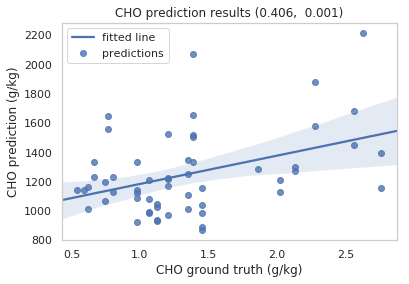

In [18]:
correlation_CHO = str(scipy.stats.pearsonr(x_CHO, y_CHO))
correlation_CHO = str(correlation_CHO)
correlation_CHO = correlation_CHO.split(',')
correlation_CHO = correlation_CHO[0][0:6] + ', ' + correlation_CHO[1][0:6] + ')'




sns.regplot(y_CHO, x_CHO)
plt.legend(('fitted line', 'predictions'))
plt.title('CHO prediction results %s'%(correlation_CHO))
plt.xlabel('CHO ground truth (g/kg)')
plt.ylabel('CHO prediction (g/kg)')





file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/CHO/'%(scenario,
                                                              labelscaled,
                                                              str(feature_num),
                                                              str(add_demo),
                                                              str(relative_AUC))

      
        
if not os.path.exists(file_path):
    os.makedirs(file_path)

plt.savefig(file_path + 'all_sub')



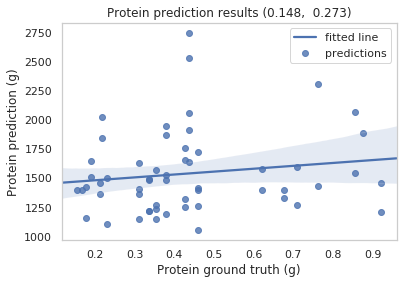

In [19]:
correlation_pro = str(scipy.stats.pearsonr(x_pro, y_pro))
correlation_pro = str(correlation_pro)
correlation_pro = correlation_pro.split(',')
correlation_pro = correlation_pro[0][0:6] + ', ' + correlation_pro[1][0:6] + ')'



sns.regplot(y_pro, x_pro)
plt.legend(('fitted line', 'predictions'))
plt.title('Protein prediction results %s'%(correlation_pro))
plt.xlabel('Protein ground truth (g)')
plt.ylabel('Protein prediction (g)')




file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/pro/'%(scenario,
                                                              labelscaled,
                                                              str(feature_num),
                                                              str(add_demo),
                                                              str(relative_AUC))

      
        
if not os.path.exists(file_path):
    os.makedirs(file_path)

plt.savefig(file_path + 'all_sub')



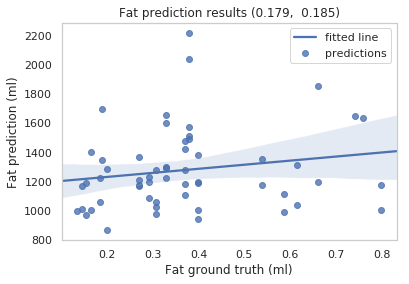

In [20]:
correlation_fat = str(scipy.stats.pearsonr(x_fat, y_fat))
correlation_fat = str(correlation_fat)
correlation_fat = correlation_fat.split(',')
correlation_fat = correlation_fat[0][0:6] + ', ' + correlation_fat[1][0:6] + ')'





sns.regplot(y_fat, x_fat)
plt.legend(('fitted line', 'predictions'))
plt.title('Fat prediction results %s'%(correlation_fat))
plt.xlabel('Fat ground truth (ml)')
plt.ylabel('Fat prediction (ml)')





file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/fat/'%(scenario,
                                                              labelscaled,
                                                              str(feature_num),
                                                              str(add_demo),
                                                              str(relative_AUC))

      
        
if not os.path.exists(file_path):
    os.makedirs(file_path)

plt.savefig(file_path + 'all_sub')




In [21]:
sub_to_correlation

{'38A': {'CHO': '(0.809,  0.014)',
  'pro': '(0.587,  0.125)',
  'fat': '(0.776,  0.023)'},
 '38B': {'CHO': '(0.388,  0.388)',
  'pro': '(0.280,  0.543)',
  'fat': '(0.519,  0.232)'},
 '38C': {'CHO': '(0.682,  0.062)',
  'pro': '(0.339,  0.410)',
  'fat': '(0.297,  0.473)'},
 '38D': {'CHO': '(0.382,  0.309)',
  'pro': '(0.013,  0.972)',
  'fat': '(-0.01,  0.977)'},
 '38E': {'CHO': '(0.697,  0.036)',
  'pro': '(0.346,  0.360)',
  'fat': '(0.395,  0.291)'},
 '38F': {'CHO': '(0.627,  0.096)',
  'pro': '(-0.04,  0.924)',
  'fat': '(0.115,  0.785)'},
 '38H': {'CHO': '(0.344,  0.449)',
  'pro': '(-0.03,  0.932)',
  'fat': '(-0.29,  0.526)'}}

In [22]:
#mean of all correlation and std

for comp in all_comp_list:

    corr_all_sub_list = []

    for sub in sub_to_correlation:
    
        corr_all_sub_list += [float(sub_to_correlation[sub][comp][1:7])]
        
    corr_all_sub_list = np.asarray(corr_all_sub_list)
        
    print(comp + ' correlation:')
    
    
    print('mean ' + str(np.mean(corr_all_sub_list)))

    print('std ' + str(np.std(corr_all_sub_list)))
        
    print()
    
    
    
        
        
    if comp == 'CHO':
            file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/CHO/'%(scenario,
                                                                          labelscaled,
                                                                          str(feature_num),
                                                                          str(add_demo),
                                                                          str(relative_AUC))
            
    elif comp == 'pro':
        file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/pro/'%(scenario,
                                                                      labelscaled,
                                                                      str(feature_num),
                                                                      str(add_demo),
                                                                      str(relative_AUC))

    elif comp == 'fat':
        file_path = './%s/label=%s|f_num=%s|demo=%s|Re_AUC=%s|/fat/'%(scenario,
                                                                      labelscaled,
                                                                      str(feature_num),
                                                                      str(add_demo),
                                                                      str(relative_AUC))

    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
    with open(file_path + comp +'.txt', 'w') as f0:
        f0.write(comp + ' correlation:\n')
        f0.write('mean ' + str(np.mean(corr_all_sub_list)) + '\n')
        f0.write('std ' + str(np.std(corr_all_sub_list))+ '\n')

ValueError: could not convert string to float: '0.809,'